- Project: Companion Bot
- Team: Yuxin Liang, Tiantian Ma
- CS6140 Machine Learning - Fall 2025

# Empaphetic Dialogues Dataset: Understanding and Pre-Processing
The Empathetic Dialogues (https://huggingface.co/datasets/facebook/empathetic_dialogues) is a dataset of about 25,000 conversations grounded in emotional situations. Each conversation includes a context column representing one speaker’s emotion from 32 categories, a prompt describing the background of the situation, and a multi-turn dialogue between speakers.


**For our project, we can use the Empathetic Dialogues to fine tune a text-generation model to generate context-aware and empathetic responses.**

# Import Modules and Install Packages

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans  # Use MiniBatch K-means to save computation
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

In [35]:
!pip install --upgrade transformers sentence-transformers

# Dataset - Emphaphetic Diaplogues

## Data Loading

In [36]:
# Download and decompress the original data
!wget -q https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
!tar -xvzf empatheticdialogues.tar.gz

empatheticdialogues/
empatheticdialogues/test.csv
empatheticdialogues/train.csv
empatheticdialogues/valid.csv


In [37]:
# File paths
# train dataset
ed_train_csv = "empatheticdialogues/train.csv"
# validation dataset
ed_validation_csv = "empatheticdialogues/valid.csv"
# test dataset
ed_test_csv = "empatheticdialogues/test.csv"

In [38]:
# Read safely using csv.DictReader
def read_csv_safe(file_path):
    data = []
    with open(file_path, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            data.append(row)
    return pd.DataFrame(data)

In [39]:
# # Read data in dataframe format
ed_train_df = read_csv_safe(ed_train_csv)
ed_valid_df = read_csv_safe(ed_validation_csv)
ed_test_df = read_csv_safe(ed_test_csv)

In [40]:
# show all texts
pd.set_option('display.max_colwidth', None)

In [41]:
# Show a few data samples
ed_train_df.head(10)

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags,None
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,1,I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people_comma_ we felt like the only people in the world.,5|5|5_2|2|5,,NaN
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,0,Was this a friend you were in love with_comma_ or just a best friend?,5|5|5_2|2|5,,NaN
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,1,This was a best friend. I miss her.,5|5|5_2|2|5,,NaN
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,0,Where has she gone?,5|5|5_2|2|5,,NaN
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,1,We no longer talk.,5|5|5_2|2|5,,NaN
5,hit:0_conv:1,6,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,0,Oh was this something that happened because of an argument?,5|5|5_2|2|5,,NaN
6,hit:1_conv:2,1,afraid,i used to scare for darkness,2,it feels like hitting to blank wall when i see the darkness,4|3|4_3|5|5,,NaN
7,hit:1_conv:2,2,afraid,i used to scare for darkness,3,Oh ya? I don't really see how,4|3|4_3|5|5,,NaN
8,hit:1_conv:2,3,afraid,i used to scare for darkness,2,dont you feel so.. its a wonder,4|3|4_3|5|5,,NaN
9,hit:1_conv:2,4,afraid,i used to scare for darkness,3,I do actually hit blank walls a lot of times but i get by,4|3|4_3|5|5,,NaN


In [42]:
# Show data size
print("Train size:", len(ed_train_df))
print("Valid size:", len(ed_valid_df))
print("Test size:", len(ed_test_df))

Train size: 76673
Valid size: 12030
Test size: 10943


## Data Preprocessing

### Drop Empty & Unnecessary Columns

In [43]:
# Drop "selfval", "tags", and None empty columns
ed_train_df = ed_train_df[['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance']]
ed_valid_df = ed_valid_df[['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance']]
ed_test_df = ed_test_df[['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance']]

In [44]:
ed_train_df.head()

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,1,I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people_comma_ we felt like the only people in the world.
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,0,Was this a friend you were in love with_comma_ or just a best friend?
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,1,This was a best friend. I miss her.
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,0,Where has she gone?
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,1,We no longer talk.


### Check and Remove Empty & Duplicated Data

In [45]:
# Check if there exists any empty value
print(ed_train_df.isna().any().any())
print(ed_valid_df.isna().any().any())
print(ed_test_df.isna().any().any())

False
False
False


- Note: doesn't exist any empty values

In [46]:
# Check if there exists duplicated (context, utterance) pairs
print(ed_train_df.duplicated(subset=['context', 'utterance']).sum())
print(ed_valid_df.duplicated(subset=['context', 'utterance']).sum())
print(ed_test_df.duplicated(subset=['context', 'utterance']).sum())

510
16
13


- Note: There exists duplicated (context, utterance) pairs: 510 duplicates in train set, 16 duplicates in valid set, and 13 in test set

In [47]:
# Show duplicated pairs
ed_train_pair_counts = ed_train_df.groupby(['context', 'utterance']).size().reset_index(name='count') # group same (context, utterance) pairs with group size
ed_train_duplicate_pairs = ed_train_pair_counts[ed_train_pair_counts['count'] > 1] # filter group with size > 1
ed_train_duplicate_pairs

,context,utterance,count
2,afraid,I used to be afraid of the dark but now I am not so much_comma_ I had a nightlight for a long time,5
1386,afraid,Oh no_comma_ what happened?,2
1468,afraid,Our home was broken into right after we moved in.,4
1826,afraid,Was it cold?,2
1911,afraid,What happened?,2
...,...,...,...
75984,trusting,he left the gate open and my dog ran away,2
75985,trusting,he ran away,4
76011,trusting,i knew i shouldnt have trusted by brother to care for my dog,2
76013,trusting,i knew i shouldnt have trusted my brother with my dog,10


In [48]:

ed_valid_pair_counts = ed_valid_df.groupby(['context', 'utterance']).size().reset_index(name='count')
ed_valid_duplicate_pairs = ed_valid_pair_counts[ed_valid_pair_counts['count'] > 1]
ed_valid_duplicate_pairs

,context,utterance,count
338,afraid,hi,2
1786,anxious,Oh no_comma_ what happened?,2
3818,devastated,It is funny how you can be going through life thinking everything is great_comma_ and then one day you find a nude of another dude that isn't you on your wife's computer. Makes for a wonderful day!,2
4768,disgusted,nobody hurted me _comma_ it's just seeing people get hurt is kind of annoying for me,2
6537,guilty,Did it taste good?,2
8313,joyful,hi,2
8432,lonely,I am sorry to hear that_comma_ why did you move there?,2
8816,nostalgic,Don't you wish you knew you were living in the good ol days while your going through them,2
9139,prepared,5,2
9370,prepared,Thank you!,2


In [49]:
ed_test_pair_counts = ed_test_df.groupby(['context', 'utterance']).size().reset_index(name='count')
ed_test_duplicate_pairs = ed_test_pair_counts[ed_test_pair_counts['count'] > 1]
ed_test_duplicate_pairs

,context,utterance,count
1538,anxious,My husband usually gets a substantial bonus this time of the year_comma_ but there's no guarantee. It's difficult waiting_comma_ and not knowing!,2
3397,devastated,My dog got hit by a car.,2
3921,disgusted,5,2
5548,grateful,Congratulations! What did you name her?,2
5628,grateful,I named her Dixie! She is a little basset hound.,2
6208,guilty,nothing,2
6219,guilty,thank you,2
6959,jealous,I caught my boyfriend texting his ex,2
7580,joyful,and how was it? did you enjoy it?,2
8336,prepared,I am prepared to go camping tonight in the woods,2


In [50]:
# Remove duplicated (context, utterance) pairs
ed_train_df = ed_train_df.drop_duplicates(subset=['context', 'utterance'])
ed_valid_df = ed_valid_df.drop_duplicates(subset=['context', 'utterance'])
ed_test_df = ed_test_df.drop_duplicates(subset=['context', 'utterance'])

In [51]:
ed_train_df.head()

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,1,I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people_comma_ we felt like the only people in the world.
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,0,Was this a friend you were in love with_comma_ or just a best friend?
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,1,This was a best friend. I miss her.
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,0,Where has she gone?
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.,1,We no longer talk.


### Remove Placeholders
Note: this dataset has a lot of "\_comma_" placeholders

In [52]:
# use regular regression to find placeholder with "_[a-z]+_"format
def find_placeholders(df):
    all_text = ' '.join(df['utterance'].astype(str) + ' ' + df['prompt'].astype(str))
    return set(re.findall(r'_[a-z]+_', all_text))

print("Train:", find_placeholders(ed_train_df))
print("Valid:", find_placeholders(ed_valid_df))
print("Test:", find_placeholders(ed_test_df))


Train: {'_comma_'}
Valid: {'_comma_'}
Test: {'_comma_'}


In [53]:
# prepare a function to clean placeholder
def clean_placeholders(text):
    if pd.isna(text):
        return text
    return str(text).replace('_comma_', ',')

In [54]:
# Clean train, valid, test set
ed_train_df['prompt'] = ed_train_df['prompt'].apply(clean_placeholders)
ed_train_df['utterance'] = ed_train_df['utterance'].apply(clean_placeholders)

ed_valid_df['prompt'] = ed_valid_df['prompt'].apply(clean_placeholders)
ed_valid_df['utterance'] = ed_valid_df['utterance'].apply(clean_placeholders)

ed_test_df['prompt'] = ed_test_df['prompt'].apply(clean_placeholders)
ed_test_df['utterance'] = ed_test_df['utterance'].apply(clean_placeholders)

In [55]:
# check after cleaning
ed_train_df.head()

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance
0,hit:0_conv:1,1,sentimental,"I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.",1,"I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people, we felt like the only people in the world."
1,hit:0_conv:1,2,sentimental,"I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.",0,"Was this a friend you were in love with, or just a best friend?"
2,hit:0_conv:1,3,sentimental,"I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.",1,This was a best friend. I miss her.
3,hit:0_conv:1,4,sentimental,"I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.",0,Where has she gone?
4,hit:0_conv:1,5,sentimental,"I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.",1,We no longer talk.


## Data Analysis

### Show Data Shapes

In [56]:
# train data
ed_train_df.shape

(76163, 6)

In [57]:
# validation data
ed_valid_df.shape

(12014, 6)

In [58]:
# test data
ed_test_df.shape

(10930, 6)

In [59]:
# Copy data for analysis
ed_train_df_copy = ed_train_df.copy()
ed_val_df_copy = ed_valid_df.copy()
ed_test_df_copy = ed_test_df.copy()

### Context (Emotion)  Distribution

In [60]:
# Count context categories
ed_train_counts = ed_train_df_copy['context'].value_counts()
ed_valid_counts = ed_val_df_copy['context'].value_counts()
ed_test_counts = ed_test_df_copy['context'].value_counts()

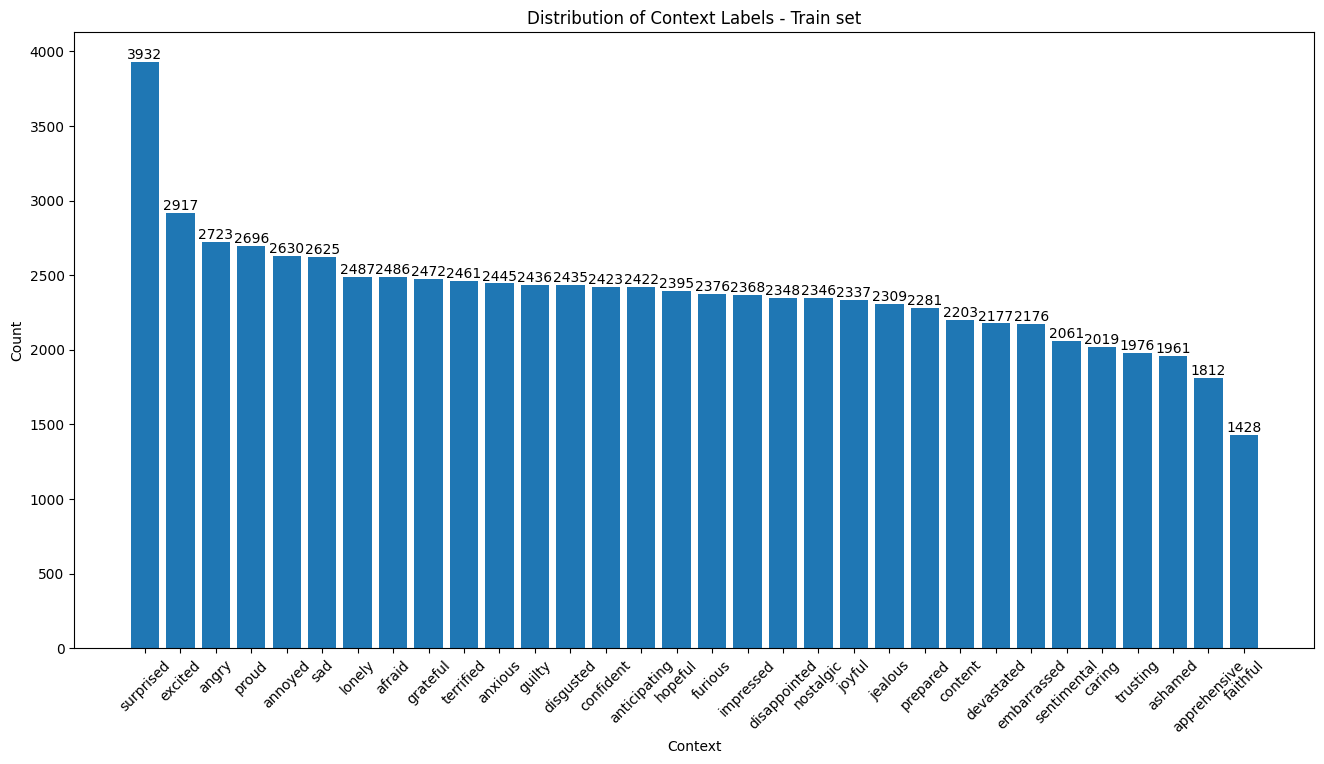

In [61]:
# Plot the context(emption) category distribution for train set
plt.figure(figsize=(16, 8))
plt.bar(ed_train_counts.index, ed_train_counts.values)

for i, v in enumerate(ed_train_counts.values):
  plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.title('Distribution of Context Labels - Train set')
plt.xlabel('Context')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

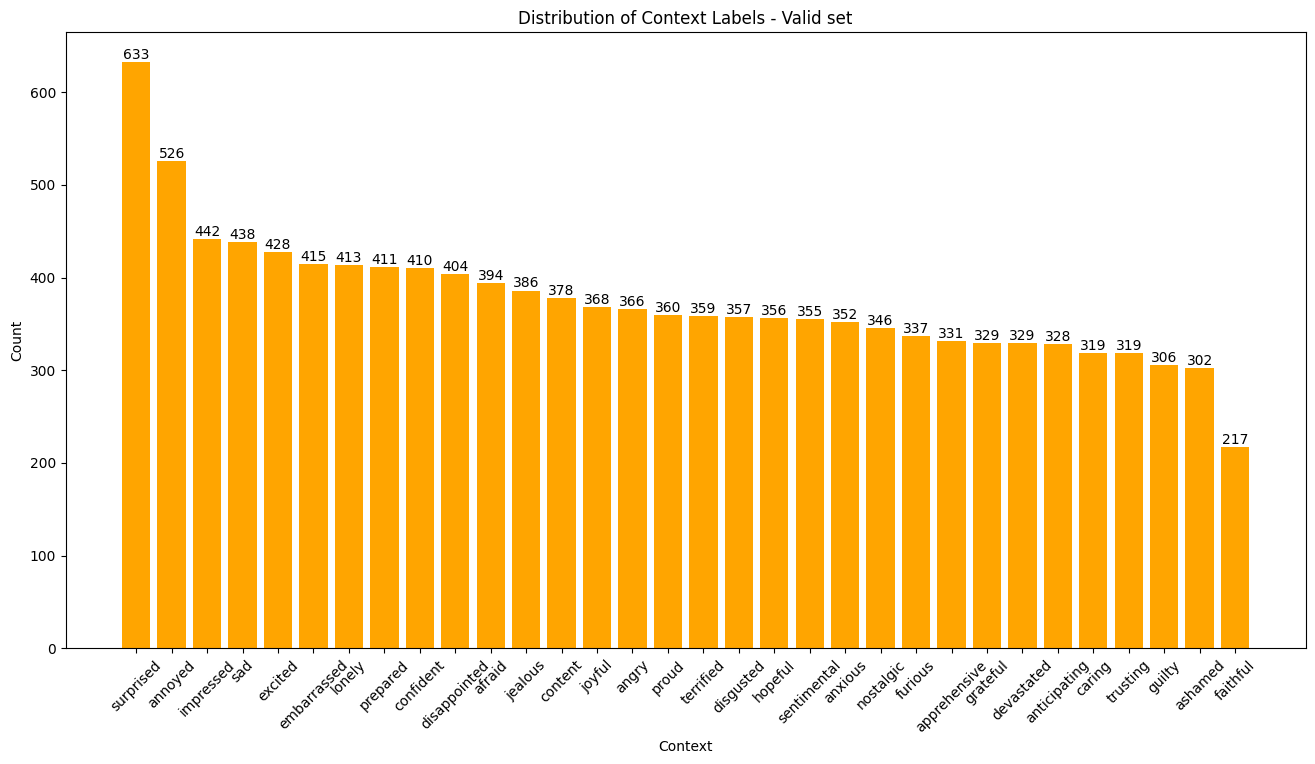

In [62]:
# Plot the context(emption) category distribution for valid set
plt.figure(figsize=(16, 8))

plt.bar(ed_valid_counts.index, ed_valid_counts.values, color='orange')

for i, v in enumerate(ed_valid_counts.values):
  plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.title('Distribution of Context Labels - Valid set')
plt.xlabel('Context')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

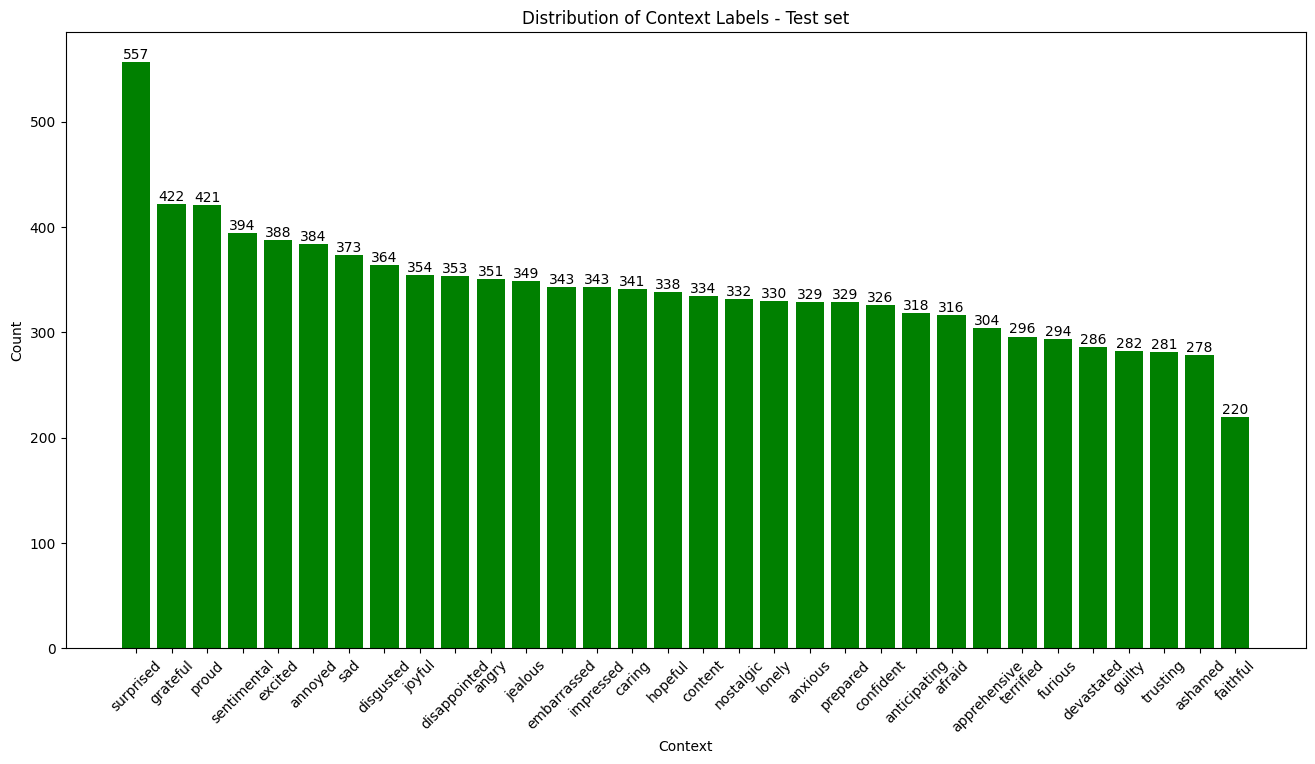

In [63]:
# Plot the context(emotion) category distribution for test set
plt.figure(figsize=(16, 8))

plt.bar(ed_test_counts.index, ed_test_counts.values, color='green')

for i, v in enumerate(ed_test_counts.values):
  plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.title('Distribution of Context Labels - Test set')
plt.xlabel('Context')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Summary of Context Distribution
The train, validation, and test sets have similar distributions of context. Among the context categories, 'surprised' has the most samples, while 'faithful' has the fewest. The other categories have relatively similar numbers of samples. There is some imbalance in the dataset, but it is not extreme. Overall, there is a relatively balanced distribution of samples in terms of context (emotion).

### Additional Analysis - Content Distribution (for additional understanding of data)

#### Utterance Content Distribution - TD-IDF, PCA, and K-means

In [64]:
# TF-IDF vectorization
ed_tfidf_vectorizer = TfidfVectorizer(max_features=2000)
ed_tfidf_X = ed_tfidf_vectorizer.fit_transform(ed_train_df_copy['utterance'])

- TF-IDF transforms words into vectors based on frequency.

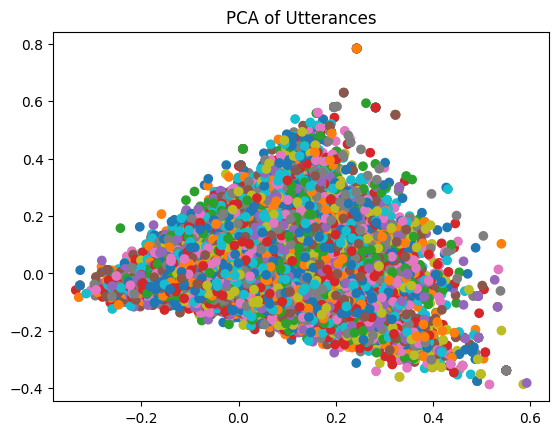

In [65]:
# Use PCA to reduce dimensions to 2D to display utterance distribution
ed_tfidf_pca = PCA(n_components=2)
ed_tfidf_X_pca = ed_tfidf_pca.fit_transform(ed_tfidf_X.toarray())

plt.scatter(ed_tfidf_X_pca[:,0], ed_tfidf_X_pca[:,1], c=pd.factorize(ed_train_df_copy['context'])[0], cmap='tab10') # show data samples with "context" in different colors
plt.title('PCA of Utterances')
plt.show()

- The points form a roughly triangular distribution with significant overlap between different contexts, suggesting that the original context categories don't correspond to clearly separable clusters in the TF-IDF feature space.

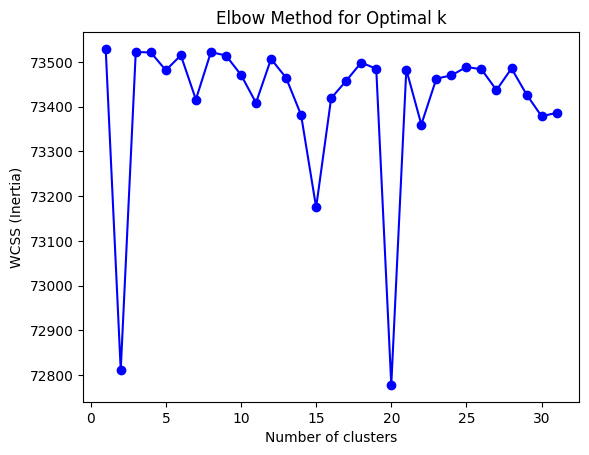

In [66]:
ed_tfidf_wcss = [] # within-cluster sum of squares (wcss)
ed_tfidf_K = range(1, 32)  # test 1~32 clusters

for k in ed_tfidf_K:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=41)
    kmeans.fit(ed_tfidf_X.toarray())
    ed_tfidf_wcss.append(kmeans.inertia_)  # inertia_ = within-cluster sum of squares (sum of squares of distances of every point in each cluster to its cluster centroid)

# plot
plt.plot(ed_tfidf_K, ed_tfidf_wcss, color='blue', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

- Instead of showing a smooth decreasing curve, the diagram exhibits erratic behavior with sharp drops at k=2, k=15, and k=20. The elbow method for K-means clustering does not show a clear "elbow" point, suggesting the absence of a natural cluster structure from a word-frequency perspective.

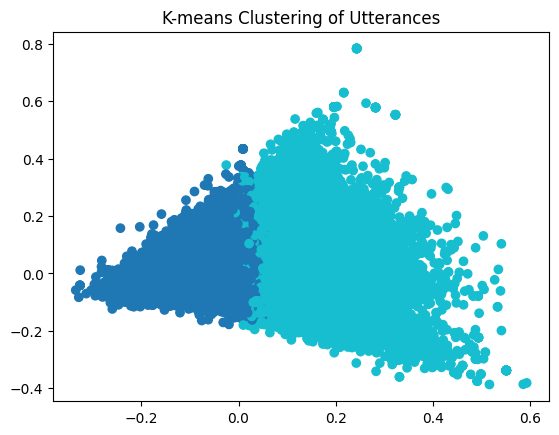

In [67]:
# Use K-means for clustering (cluster = 2)
ed_tfidf_kmeans = KMeans(n_clusters=2, random_state=41)
ed_tfidf_kmeans_labels = ed_tfidf_kmeans.fit_predict(ed_tfidf_X.toarray())

plt.scatter(ed_tfidf_X_pca[:,0], ed_tfidf_X_pca[:,1], c=ed_tfidf_kmeans_labels, cmap='tab10')
plt.title('K-means Clustering of Utterances')
plt.show()

- With 2 clusters, K-means creates a clean binary partition but may be too coarse to capture meaningful semantic distinctions in the utterances.

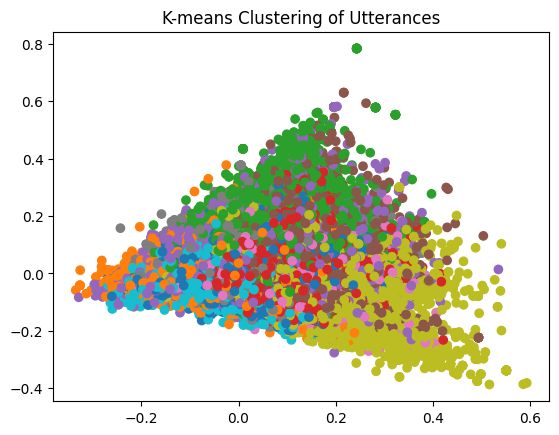

In [68]:
# Use K-means for clustering (cluster = 20)
ed_tfidf_kmeans = KMeans(n_clusters=20, random_state=41)
ed_tfidf_kmeans_labels = ed_tfidf_kmeans.fit_predict(ed_tfidf_X.toarray())

plt.scatter(ed_tfidf_X_pca[:,0], ed_tfidf_X_pca[:,1], c=ed_tfidf_kmeans_labels, cmap='tab10')
plt.title('K-means Clustering of Utterances')
plt.show()

- Compared to to K=2, the 20 clusters show mixing and overlap, indicating that K-means struggles to find well-separated clusters

- All the results show significant overlap between different emotion categories in the feature space, indicating that utterances expressing different emotions share similar vocabulary patterns and cannot be easily distinguished based on lexical features alone.

#### Utterance Content Distribution - SentenceTransformer & K-means

In [69]:
# Text vectorization (based on semactic meaning)
ed_st_model = SentenceTransformer('all-MiniLM-L6-v2')
ed_st_embeddings = ed_st_model.encode(ed_train_df_copy['utterance'].tolist(), batch_size=32, show_progress_bar=True)

# K-means Clustering
ed_st_kmeans = KMeans(n_clusters=20, random_state=41)
ed_train_df_copy['cluster'] = ed_st_kmeans.fit_predict(ed_st_embeddings)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2381 [00:00<?, ?it/s]

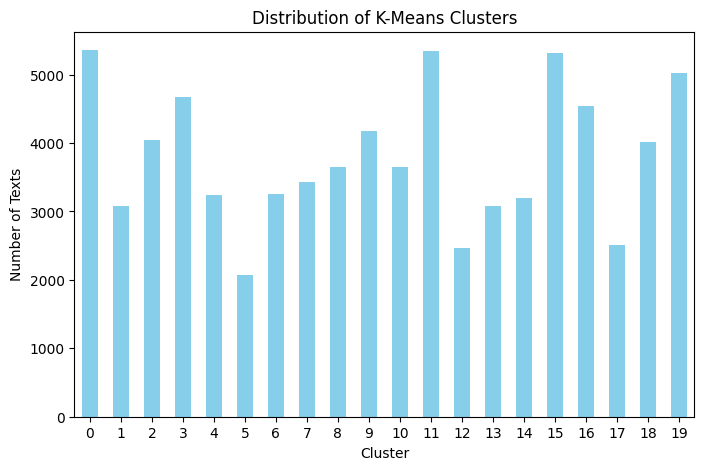

In [70]:
# Show similar content distribution
ed_st_cluster_counts = ed_train_df_copy['cluster'].value_counts().sort_index()

plt.figure(figsize=(8,5))
ed_st_cluster_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Texts')
plt.title('Distribution of K-Means Clusters')
plt.xticks(rotation=0)
plt.show()

- Sentence Transformer embeddings (all-MiniLM-L6-v2) with K-means clustering (k=20) are used to analyze the distribution of semantic content. The resulting cluster distribution was relatively balanced, with most clusters containing between 2,000 and 5,500 utterances. This indicates that the dataset encompasses a variety of semantic topics without any single theme dominating the dataset.

## Data Preparation For Fine-tuning (Save in JSON Format)

In [71]:
# prepare function that converts Emphaphetic Dialogues data to training format
def convert_to_training_format(df):
    training_data = []

    for conv_id, conv_df in df.groupby('conv_id'):
        conv_df = conv_df.sort_values('utterance_idx')
        emotion = conv_df['context'].iloc[0]
        prompt = conv_df['prompt'].iloc[0]

        user_id = conv_df['speaker_idx'].iloc[0] # speaker of the first message in a conversation is the user

        dialogue_history = f"[{emotion}]\nContext: {prompt}\n" # one per conversation to keep conversation history

        for _, row in conv_df.iterrows():
            if row['speaker_idx'] == user_id:  # user
                dialogue_history += f"User: {row['utterance']}\n"
            else:  # chatbot
                dialogue_history += f"Chatbot: {row['utterance']}\n"
                # save one piece of training data each time after the chatbot replies
                training_data.append({"text": dialogue_history.strip()})

    return training_data

In [72]:
# define a function to save data in json file
def save_to_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

In [73]:

# Convert train, validate, test data
ed_training_train = convert_to_training_format(ed_train_df)
ed_training_valid = convert_to_training_format(ed_valid_df)
ed_training_test = convert_to_training_format(ed_test_df)

# Show the first two pieces of the converted train data
for item in ed_training_train[:10]:
    print(item['text'])
    print('---')

[sentimental]
Context: I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.
User: I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people, we felt like the only people in the world.
Chatbot: Was this a friend you were in love with, or just a best friend?
---
[sentimental]
Context: I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.
User: I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people, we felt like the only people in the world.
Chatbot: Was this a friend you were in love with, or just a best friend?
User: This was a best friend. I miss her.
Chatbot: Where has she gone?
---
[sentimental]
Context: I remember going to the fireworks with my best friend. There w

In [74]:
# Save data to json file
save_to_json(ed_training_train, 'emphaphetic_dialogues_finetune_train.json')
save_to_json(ed_training_valid, 'emphaphetic_dialogues_finetune_valid.json')
save_to_json(ed_training_test, 'emphaphetic_dialogues_finetune_test.json')